In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams["font.size"] = 16

file_path = '../results/decoder_layer_batch_size.csv'

x_dict = {  
            '4096_14336_8': 'Mixtral-8x7B', 
            '2304_5760_8':  'MiniCPM-MoE', 
            '6144_16384_8': 'Mixtral-8x22B', 
            '3072_12288_32':'OpenMoE-34B',
            '2048_1408_64': 'DeepSeek-MoE',
            '2048_1408_60': 'Qwen2-MoE'
          }

order = ['MiniCPM-MoE', 'OpenMoE-34B', 'Mixtral-8x7B', 'Mixtral-8x22B', 'Qwen2-MoE', 'DeepSeek-MoE']

raw_df = pd.read_csv(file_path)

In [2]:
def select_data(df, para=(4096,14336,8), mode='eager', batch_sizes=None):
    coloum_names = ['batch_size']
    names = ['GEMM', 'megablocks', 'vLLM', 'Samoyeds']

    select_df = pd.DataFrame(columns = coloum_names + names)
    max_batch_idx = {name: -1 for name in names}
    select_df.set_index('batch_size', inplace=True)
    
    for index, row in df.iterrows():
        batch_size = row['batch_size']
        
        hidden_size = row['hidden_size']
        intermediate_size = row['intermediate_size']
        expert_num = row['expert_num']
        
        kernel = row['kernel type']
        
        time = row['time']
        
        if mode != row['atten_mode']:
            continue
        if (hidden_size, intermediate_size, expert_num) != para:
            continue
        if batch_sizes!=None and batch_size not in batch_sizes:
            continue
        
        if batch_size not in select_df.index:
            select_df.loc[batch_size] = [np.nan for _ in range(len(select_df.columns))]
        select_df.at[batch_size, kernel] = time
        max_batch_idx[kernel] += 1
    
    return select_df, max_batch_idx

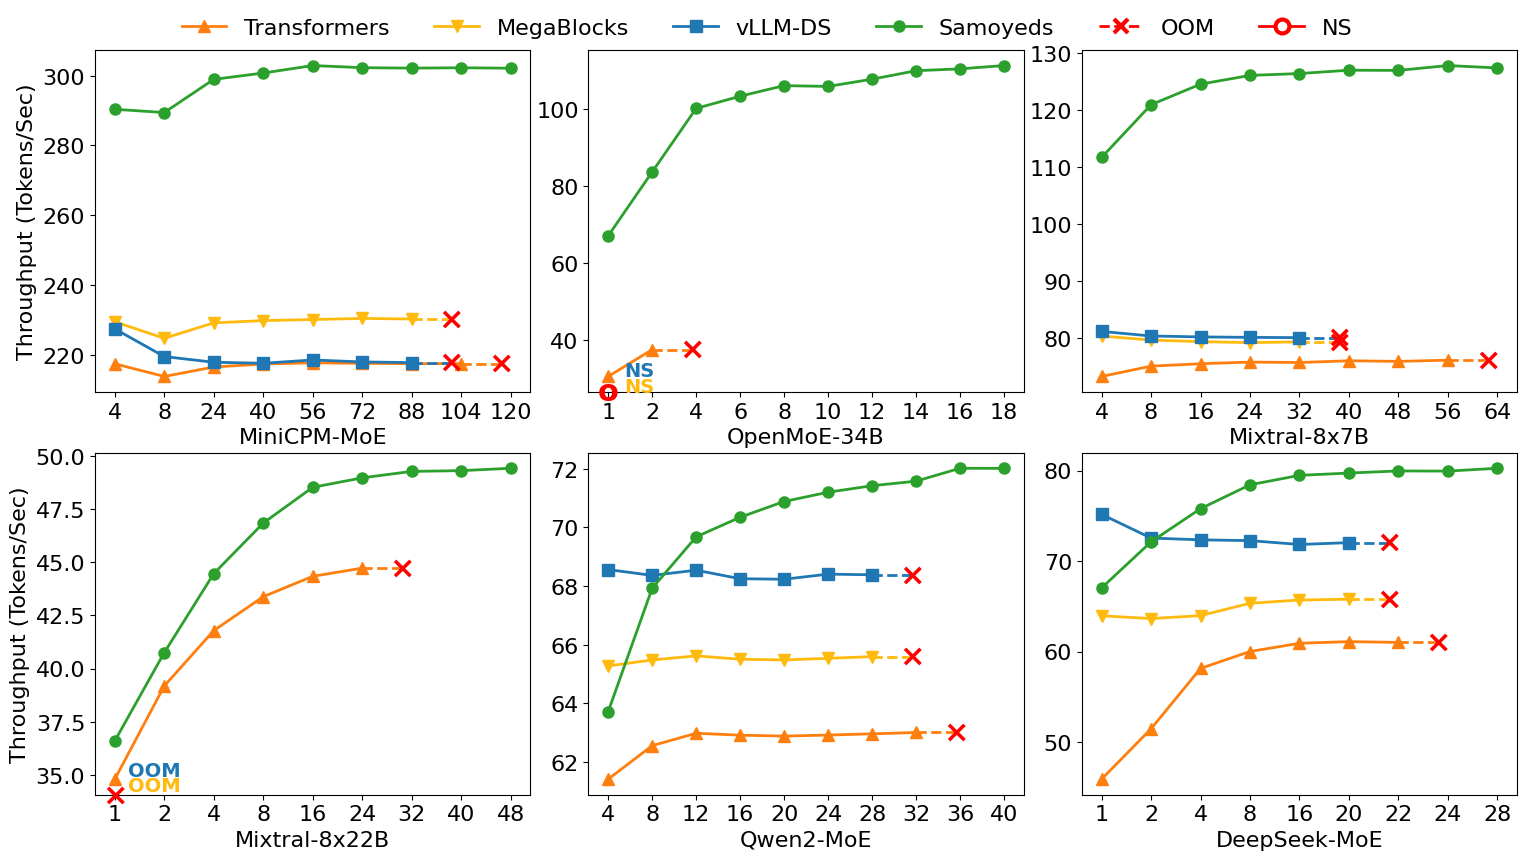

In [3]:
para_list = [(2304,5760,8,0,0,'MiniCPM-MoE',[4,8,24,40,56,72,88,104,120]), 
             (3072,12288,32,0,1,'OpenMoE-34B',[1,2,4,6,8,10,12,14,16,18]), 
             (4096,14336,8,0,2,'Mixtral-8x7B',[4,8,16,24,32,40,48,56,64]), 
             (6144,16384,8,1,0,'Mixtral-8x22B',[1,2,4,8,16,24,32,40,48]),  
             (2048,1408,60,1,1,'Qwen2-MoE',[4,8,12,16,20,24,28,32,36,40]),
             (2048,1408,64,1,2,'DeepSeek-MoE',[1,2,4,8,16,20,22,24,26,28,30])]
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 创建子图网格

for (hidden_size, intermediate_size, expert_num, row_idx, col_idx, name, batch_sizes) in para_list:
    data_eager, max_batch_idx = select_data(raw_df, para=(hidden_size, intermediate_size, expert_num), mode='flash_attention_2', batch_sizes=batch_sizes)

    data_eager['megablocks'] = 1 / (data_eager['megablocks'] / 100 / data_eager.index / 1000)
    data_eager['vLLM'] = 1 / (data_eager['vLLM'] / 100 / data_eager.index / 1000)
    data_eager['Samoyeds'] = 1 / (data_eager['Samoyeds'] / 100 / data_eager.index / 1000)
    data_eager['GEMM'] = 1 / (data_eager['GEMM'] / 100 / data_eager.index/ 1000)    
    
    data_eager.rename(columns={'GEMM': 'Transformers', 'megablocks': 'MegaBlocks', 'vLLM': 'vLLM-DS', 'Samoyeds': 'Samoyeds'}, inplace=True)
    name_to_data_idx = {'Transformers':'GEMM', 'MegaBlocks': 'megablocks', 'vLLM-DS': 'vLLM', 'Samoyeds': 'Samoyeds'}


    markers = ['^', 'v', 's', 'o']
    maximum_marker = 'X'

    colors = ['#ff7f0e', '#ffba0d', '#1f77b4', '#2ca02c']
    x = np.linspace(0, 1, len(data_eager))
    for i, column in enumerate(data_eager.columns):
        if column == 'Samoyeds':
            axs[row_idx, col_idx].plot(x, data_eager[column], linewidth=2, marker=markers[i % len(markers)], markersize=8, label=column, color=colors[i])
        else:
            normal_idx = max_batch_idx[name_to_data_idx[column]]
            axs[row_idx, col_idx].plot(x, data_eager[column], linewidth=2, marker=markers[i % len(markers)], markersize=8, label=column, color=colors[i])

            if normal_idx > 0 and normal_idx < data_eager[column].shape[0]:
                axs[row_idx, col_idx].hlines(data_eager[column].iloc[normal_idx], xmin=x[normal_idx], xmax=x[normal_idx]+max(0.1, 1/len(x)/2), color=colors[i], linewidth=2, linestyle='dashed')
                axs[row_idx, col_idx].text(x[normal_idx]+max(0.1, 1/len(x)/2), data_eager[column].iloc[normal_idx], f'\u00D7', ha='center', va='center', fontsize=22, color='red', weight='bold')
        
    if name == 'Mixtral-8x22B':
        axs[row_idx, col_idx].text(0, axs[row_idx, col_idx].get_ylim()[0], f'\u00D7', ha='center', va='center', fontsize=22, color='red', weight='bold')
        axs[row_idx, col_idx].text(0.1, 34.5, f'OOM', ha='center', va='center', fontsize=14, color=colors[1], weight='bold')
        axs[row_idx, col_idx].text(0.1, 35.2, f'OOM', ha='center', va='center', fontsize=14, color=colors[2], weight='bold')
        
        pass
    if name == 'OpenMoE-34B':
        axs[row_idx, col_idx].text(0, axs[row_idx, col_idx].get_ylim()[0], f'o', ha='center', va='center', fontsize=22, color='red', weight='bold')
        axs[row_idx, col_idx].text(0.08, 28, f'NS', ha='center', va='center', fontsize=14, color=colors[1], weight='bold')
        axs[row_idx, col_idx].text(0.08, 32, f'NS', ha='center', va='center', fontsize=14, color=colors[2], weight='bold')

        pass
    
    if col_idx == 0:
        axs[row_idx, col_idx].set_ylabel("Throughput (Tokens/Sec)")
    axs[row_idx, col_idx].set_xlabel(name)

    # Customize the ticks for better readability
    axs[row_idx, col_idx].set_xticks(x)
    axs[row_idx, col_idx].set_xticklabels(data_eager.index)
    
    data_eager['MegaBlocks'] = data_eager['Samoyeds'] / data_eager['MegaBlocks']
    data_eager['vLLM-DS'] = data_eager['Samoyeds'] / data_eager['vLLM-DS']
    data_eager['Transformers'] = data_eager['Samoyeds'] / data_eager['Transformers']
    data_eager['Samoyeds'] = data_eager['Samoyeds'] / data_eager['Samoyeds']

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='x', color='r', label='Scatter', linestyle='--', lw=2, markeredgewidth=3,
                          markerfacecolor='red', markersize=10),
                   Line2D([0], [0], marker='o', color='r', label='Scatter', lw=2,
                          markerfacecolor='w', markersize=10, markeredgewidth=3)]
handles, labels = axs[0, 0].get_legend_handles_labels()
handles = handles + legend_elements
labels = labels + ['OOM', 'NS']
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.99), ncol=6, frameon=False) 

plt.tight_layout(pad=0) 

plt.show() 

